# **Estudiantes:**
- Felipe García
- Fabian Tovar



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf


In [2]:
import sys
import os

# Obtener la ruta absoluta a la carpeta 'function'
# Sube un nivel desde 'notebooks' y luego entra a 'function'
function_path = os.path.abspath(os.path.join('..', 'function'))

# Añadir la ruta al sys.path si no está ya ahí
# Esto evita añadir la ruta múltiples veces si ejecutas la celda de nuevo
if function_path not in sys.path:
    sys.path.append(function_path)

# Ahora puedes importar tus módulos
from Methodologies_Port import *
from metrics_portfolio import *
from Portafolio_DeFi import *
from yahoo_data import *


# 1. Incorporación del activo libre de riesgo


### 1.1. Descarga y preprocesamiento
- Descargue precios ajustados diarios de los activos de riesgo y de la serie **^IRX** (T-Bill a 13 semanas) usando `yfinance`.
- Alinee calendarios de negociación y elimine faltantes en el rango de fechas definido.

In [3]:

tickers   = ["AAPL", "CX", "TSLA", "BTC-USD", "MCD"]
rf_ticker = ["^IRX"]

start_est = "2025-01-01"
end_est   = "2025-07-01"

# Descargar y alinear (usa Adj Close por defecto)
data_all = yahoo_data.preprocess_data(tickers, rf_ticker, start_est, end_est)

# Separar activos de riesgo y rf
prices_assets = data_all[tickers]
prices_rf     = data_all[rf_ticker]


In [4]:
prices_assets

Ticker,AAPL,CX,TSLA,BTC-USD,MCD
Date,,,,,
2025-01-02,242.987427,5.652203,379.279999,96886.875000,289.190674
2025-01-03,242.499161,5.622402,410.440002,98107.429688,291.434906
2025-01-06,244.133347,5.691937,411.049988,102078.085938,288.864380
2025-01-07,241.353226,5.672070,394.359985,96922.703125,286.056610
2025-01-08,241.841476,5.652203,394.940002,95043.523438,283.644318
...,...,...,...,...,...
2025-06-24,200.072937,6.940000,340.470001,106045.632812,291.470001
2025-06-25,201.331512,6.740000,327.549988,107361.257812,285.549988
2025-06-26,200.772141,6.830000,325.779999,106960.000000,285.630005


In [5]:
data_all = (
    pd.concat([prices_assets, prices_rf], axis=1, join="inner")
      .sort_index()
      .dropna(how="any")
)


In [6]:
data_all

Ticker,AAPL,CX,TSLA,BTC-USD,MCD,^IRX
Date,,,,,,
2025-01-02,242.987427,5.652203,379.279999,96886.875000,289.190674,4.208
2025-01-03,242.499161,5.622402,410.440002,98107.429688,291.434906,4.193
2025-01-06,244.133347,5.691937,411.049988,102078.085938,288.864380,4.190
2025-01-07,241.353226,5.672070,394.359985,96922.703125,286.056610,4.203
2025-01-08,241.841476,5.652203,394.940002,95043.523438,283.644318,4.205
...,...,...,...,...,...,...
2025-06-24,200.072937,6.940000,340.470001,106045.632812,291.470001,4.182
2025-06-25,201.331512,6.740000,327.549988,107361.257812,285.549988,4.188
2025-06-26,200.772141,6.830000,325.779999,106960.000000,285.630005,4.193


### 1.2. Conversión de la tasa libre de riesgo
- Interprete **^IRX** como una tasa anualizada.
- Conviértala a tasa diaria efectiva mediante la fórmula:

$$
r_{day} = (1 + r_{ann})^{1/252} - 1
$$
- Genere series de tasa libre de riesgo diaria y anual.

In [7]:
rf_ann, rf_daily = yahoo_data.convert_rf(data_all[['^IRX']] )

#### Anual

In [8]:
rf_ann

,^IRX_ann
Date,
2025-01-02,0.04208
2025-01-03,0.04193
2025-01-06,0.04190
2025-01-07,0.04203
2025-01-08,0.04205
...,...
2025-06-24,0.04182
2025-06-25,0.04188
2025-06-26,0.04193


#### Diario

In [9]:
rf_daily

,^IRX_daily
Date,
2025-01-02,0.000164
2025-01-03,0.000163
2025-01-06,0.000163
2025-01-07,0.000163
2025-01-08,0.000163
...,...
2025-06-24,0.000163
2025-06-25,0.000163
2025-06-26,0.000163


### 1.3. Exceso de retorno y exposición
- Devuelva:
  1. Retornos diarios de los activos de riesgo.
  2. Serie de tasa libre de riesgo diaria y anual.
  3. Un indicador que permita trabajar con **retornos en exceso** cuando se calcule el Sharpe ratio o el portafolio tangente.

In [10]:
rets_assets = yahoo_data.compute_returns_from_prices(data_all, kind="log")
rets_excess = yahoo_data.excess_returns(rets_assets, rf_daily)

print("Activos (precios):", prices_assets.shape)
print("RF anualizada:", rf_ann.shape)
print("RF diaria:", rf_daily.shape)
print("Retornos activos:", rets_assets.shape)
print("Retornos en exceso:", rets_excess.shape)

Activos (precios): (122, 5)
RF anualizada: (122, 1)
RF diaria: (122, 1)
Retornos activos: (121, 6)
Retornos en exceso: (121, 6)


/media/fabian/INFO/Universidad externado/Defi3/portafolio_de_inversion/function/yahoo_data.py:164: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



# 2. Portafolio media–varianza eficiente

### 2.1 Estadísticos: μ y Σ anualizados

In [11]:
# Retornos diarios 
rets_assets = yahoo_data.compute_returns_from_prices(data_all[["AAPL", "CX", "TSLA", "BTC-USD", "MCD"]], kind="log")

# µ anualizada (vector de medias)
mu = rets_assets.mean() * 252

# Σ anualizada (matriz de covarianzas)
Sigma = rets_assets.cov() * 252

print("Vector de medias anualizadas (µ):")
print(mu)

print("\nMatriz de covarianzas anualizada (Σ):")
print(Sigma)

Vector de medias anualizadas (µ):
Ticker
AAPL      -0.354685
CX         0.424473
TSLA      -0.369238
BTC-USD    0.209407
MCD        0.021346
dtype: float64

Matriz de covarianzas anualizada (Σ):
Ticker       AAPL        CX      TSLA   BTC-USD       MCD
Ticker                                                   
AAPL     0.164515  0.062497  0.183096  0.060212  0.022654
CX       0.062497  0.164931  0.120094  0.058685  0.019255
TSLA     0.183096  0.120094  0.585327  0.174648  0.007702
BTC-USD  0.060212  0.058685  0.174648  0.182179  0.002897
MCD      0.022654  0.019255  0.007702  0.002897  0.044436


### 2.2 Optimización

In [12]:
# Retornos diarios (log)
rets_assets = yahoo_data.compute_returns_from_prices(
    data_all[["AAPL", "CX", "TSLA", "BTC-USD", "MCD"]], kind="log"
)

# µ y Σ anualizados
mu    = rets_assets.mean() * 252
Sigma = rets_assets.cov()  * 252


# Elige un retorno objetivo anual (ejemplos)
mu_target = float(mu.mean())         # la media de medias
# mu_target = float(np.quantile(mu, 0.5))  # mediana
# mu_target = 0.20         # 20% anual, si quieres fijar explícito

res = Do_portfolio.min_var_portfolio(mu, Sigma, target_return=mu_target, long_only=True)

print("Estado:", res["status"])
print("Retorno esperado:", round(res["expected_return"], 4))
print("Volatilidad:", round(res["volatility"], 4))
print("\nPesos óptimos:")
print(res["weights"])

Estado: optimal
Retorno esperado: 0.062
Volatilidad: 0.1891

Pesos óptimos:
AAPL       3.460354e-02
CX         6.165579e-02
TSLA       2.463251e-23
BTC-USD    1.531107e-01
MCD        7.506300e-01
dtype: float64


### 2.3 Implementación: frontera media–varianza

   target_return  expected_return  volatility  variance
0       0.061984         0.061984    0.189130  0.035770
1       0.077087         0.077087    0.189320  0.035842
2       0.092191         0.092191    0.189922  0.036070
3       0.107295         0.107295    0.191542  0.036688
4       0.122399         0.122399    0.194387  0.037786

PMV: {'weights': AAPL       3.460354e-02
CX         6.165579e-02
TSLA       2.463251e-23
BTC-USD    1.531107e-01
MCD        7.506300e-01
dtype: float64, 'expected_return': 0.061983579474195236, 'volatility': 0.1891295460878824, 'variance': 0.03576998520340843}


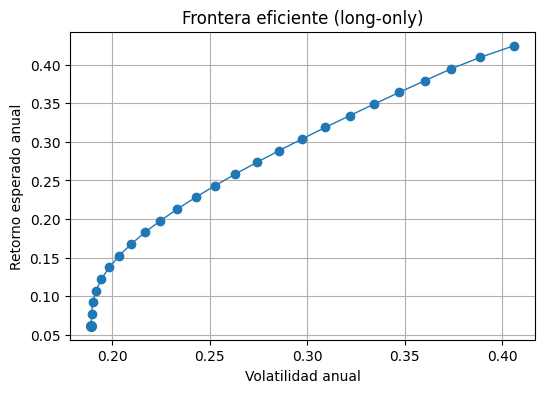

In [13]:
#  Construir la frontera (25 puntos, long-only)
ef = Do_portfolio.efficient_frontier_by_return(mu, Sigma, n_points=25, long_only=True)

curve = ef["curve"]          # target_return, expected_return, volatility, variance
weights_df = ef["weights"]   # pesos por punto (filas=puntos, columnas=tickers)
pmv = ef["pmv"]              # info del PMV

print(curve.head())
print("\nPMV:", pmv)

# Graficar (σ en X, µ en Y)
plt.figure(figsize=(6,4))
plt.plot(curve["volatility"], curve["expected_return"], marker='o', lw=1)
plt.scatter(pmv["volatility"], pmv["expected_return"], s=50)  # marca el PMV
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno esperado anual")
plt.title("Frontera eficiente (long-only)")
plt.grid(True)
plt.show()


# 3. Curva eficiente

### 3.1 Construcción de la frontera eficiente

In [14]:
# Frontera eficiente por retorno objetivo (long-only)
ef = Do_portfolio.efficient_frontier_by_return(
    mu=mu,
    Sigma=Sigma,
    n_points=30,     # puedes subir a 50-100 si deseas más resolución
    long_only=True,  # w >= 0
    solver=None      # auto (OSQP si está instalado, si no SCS)
)

curve      = ef["curve"]        # DataFrame: ['target_return','expected_return','volatility','variance']
weights_df = ef["weights"]      # DataFrame: una fila por punto, columnas = tickers
pmv        = ef["pmv"]          # dict con: weights (Serie), expected_return, volatility, variance
statuses   = ef["statuses"]     # lista de estados del solver por punto

# Filtrar por soluciones factibles/óptimas (defensivo)
ok_mask = [s in ("optimal", "optimal_inaccurate") for s in statuses]
curve_ok      = curve.loc[ok_mask].reset_index(drop=True)
weights_ok_df = weights_df.loc[ok_mask].reset_index(drop=True)

print(f"Puntos factibles en la curva: {len(curve_ok)} / {len(curve)}")
print("Primeros puntos:\n", curve_ok.head(3))
print("\nPMV (mínima varianza sin objetivo):",
      f"mu={pmv['expected_return']:.4f}, sigma={pmv['volatility']:.4f}")
print("Pesos PMV:\n", pmv["weights"].round(4))



Puntos factibles en la curva: 30 / 30
Primeros puntos:
    target_return  expected_return  volatility  variance
0       0.061984         0.061984     0.18913  0.035770
1       0.074483         0.074483     0.18926  0.035819
2       0.086983         0.086983     0.18965  0.035967

PMV (mínima varianza sin objetivo): mu=0.0620, sigma=0.1891
Pesos PMV:
 AAPL       0.0346
CX         0.0617
TSLA       0.0000
BTC-USD    0.1531
MCD        0.7506
dtype: float64


### 3.2 Gráfico Volatilidad vs Retorno esperado

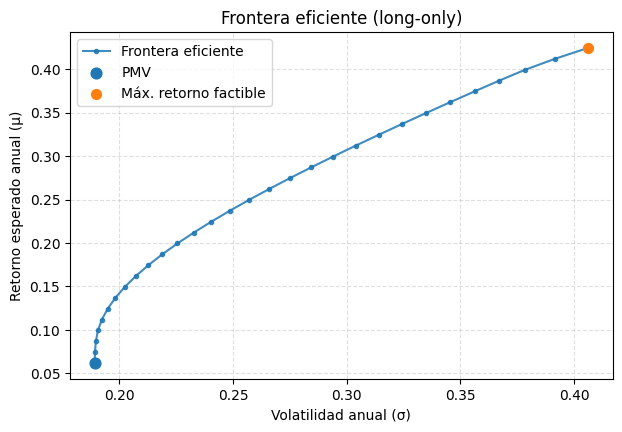

Tabla — Puntos representativos de la frontera (pesos y métricas):


,Punto,μ_target,μ_logrado,σ,w_AAPL,w_CX,w_TSLA,w_BTC-USD,w_MCD
0,BAJO,0.0620,0.0620,0.1891,0.0346,0.0617,0.0,0.1531,0.7506
1,MEDIO,0.2495,0.2495,0.2569,-0.0000,0.4916,-0.0,0.1594,0.3491
2,ALTO,0.4245,0.4245,0.4061,-0.0000,1.0000,-0.0,0.0000,-0.0000


In [15]:
# Gráfico (σ en X, μ en Y) con PMV 
plt.figure(figsize=(7, 4.5))
plt.plot(curve_ok["volatility"], curve_ok["expected_return"],
         lw=1.5, marker='o', ms=3, alpha=0.85, label="Frontera eficiente")

# Marca PMV
plt.scatter(pmv["volatility"], pmv["expected_return"], s=60, zorder=3, label="PMV")

#  marca el extremo de mayor retorno factible
imax = int(np.argmax(curve_ok["expected_return"].values))
plt.scatter(curve_ok.loc[imax, "volatility"], curve_ok.loc[imax, "expected_return"],
            s=50, zorder=3, label="Máx. retorno factible")

plt.xlabel("Volatilidad anual (σ)")
plt.ylabel("Retorno esperado anual (μ)")
plt.title("Frontera eficiente (long-only)")
plt.grid(True, ls="--", alpha=0.4); plt.legend(); plt.show()

# Tabla resumen de 3 puntos (bajo, medio, alto retorno) con pesos 
idx_low  = 0
idx_mid  = len(curve_ok)//2
idx_high = len(curve_ok)-1

# Aseguramos orden de columnas según tus tickers
tickers_order = list(prices_assets.columns)

resumen = []
for idx, tag in [(idx_low, "BAJO"), (idx_mid, "MEDIO"), (idx_high, "ALTO")]:
    fila = {
        "Punto": tag,
        "μ_target": curve_ok.loc[idx, "target_return"],
        "μ_logrado": curve_ok.loc[idx, "expected_return"],
        "σ": curve_ok.loc[idx, "volatility"],
    }
    # Añadimos pesos por activo
    for t in tickers_order:
        fila[f"w_{t}"] = weights_ok_df.loc[idx, t]
    resumen.append(fila)

tabla_resumen = pd.DataFrame(resumen)
# Formato amigable
cols_fmt = ["Punto", "μ_target", "μ_logrado", "σ"] + [f"w_{t}" for t in tickers_order]
tabla_resumen = tabla_resumen[cols_fmt].copy()
tabla_resumen[["μ_target","μ_logrado","σ"]] = tabla_resumen[["μ_target","μ_logrado","σ"]].round(4)
for t in tickers_order:
    tabla_resumen[f"w_{t}"] = tabla_resumen[f"w_{t}"].round(4)

print("Tabla — Puntos representativos de la frontera (pesos y métricas):")
display(tabla_resumen)


# 4. Portafolios especiales

### 4.1. Determine el portafolio de mínima varianza (PMV).


PMV (con lb) — métricas:
  μ (anual) = 0.0593
  σ (anual) = 0.1898

PMV (con lb) — pesos (ordenados):


,w
MCD,0.7569
BTC-USD,0.1475
CX,0.0595
AAPL,0.0261
TSLA,0.0100


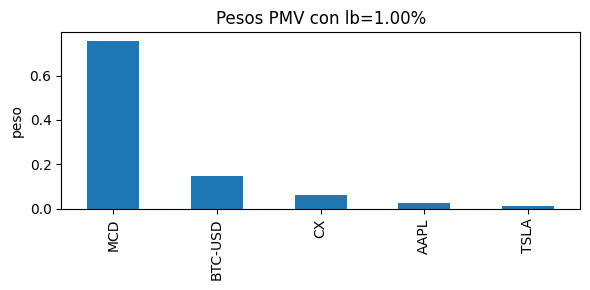

In [16]:
eps = 0.01   # 1% mínimo por activo; con 5 activos, eps*n = 0.05 <= 1  ⇒ factible

pmv_eps = Do_portfolio.pmv_info_bounded(mu, Sigma, lb=eps, ub=1.0)

print("PMV (con lb) — métricas:")   
print(f"  μ (anual) = {pmv_eps['expected_return']:.4f}")
print(f"  σ (anual) = {pmv_eps['volatility']:.4f}")

print("\nPMV (con lb) — pesos (ordenados):")
w_pmv_eps = pmv_eps["weights"].sort_values(ascending=False).round(4)
display(w_pmv_eps.to_frame("w"))

# Gráfico
w_pmv_eps.plot(kind="bar", figsize=(6,3), title=f"Pesos PMV con lb={eps:.2%}")
plt.ylabel("peso"); plt.tight_layout(); plt.show()



### 4.2. Determine el portafolio tangente (máximo ratio de Sharpe) incorporando el activo libre de riesgo.

In [17]:
# rf_ann_scalar como antes
try:
    rf_ann_scalar = float(rf_ann.iloc[-1, 0])
except Exception:
    rf_ann_scalar = float(rf_ann.squeeze().iloc[-1])

tan = Do_portfolio.tangency_portfolio(mu, Sigma, rf_ann=rf_ann_scalar, long_only=True)

print("Tangente — estado solver:", tan["status"])
print(f"  μ (anual)   = {tan['expected_return']:.4f}")
print(f"  σ (anual)   = {tan['volatility']:.4f}")
print(f"  Sharpe (rf) = {tan['sharpe']:.4f}\n")

print("Tangente — pesos (ordenados):")
display(tan["weights"].sort_values(ascending=False).round(4).to_frame("w"))

Tangente — estado solver: optimal (SCS)
  μ (anual)   = 0.4074
  σ (anual)   = 0.3866
  Sharpe (rf) = 0.9453

Tangente — pesos (ordenados):


/home/fabian/miniconda3/lib/python3.12/site-packages/scs/__init__.py:83: UserWarning:

Converting A to a CSC (compressed sparse column) matrix; may take a while.



,w
CX,0.9204
BTC-USD,0.0796
AAPL,0.0000
MCD,0.0000
TSLA,0.0000


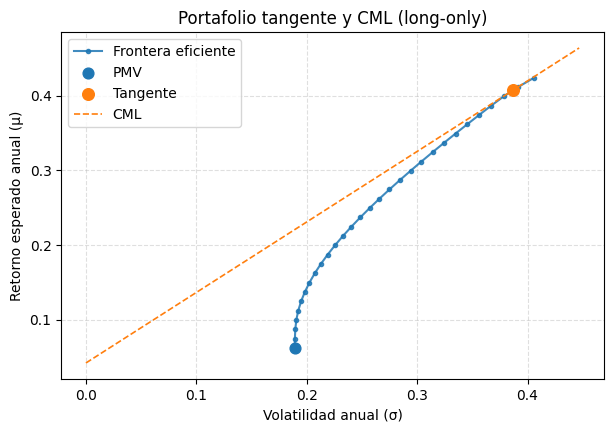

In [18]:
plt.figure(figsize=(7, 4.5))
if 'curve_ok' in globals():
    plt.plot(curve_ok["volatility"], curve_ok["expected_return"], lw=1.5, marker='o', ms=3, alpha=0.85, label="Frontera eficiente")
    plt.scatter(pmv["volatility"], pmv["expected_return"], s=60, zorder=3, label="PMV")

plt.scatter(tan["volatility"], tan["expected_return"], s=70, zorder=4, label="Tangente")
xmax = (curve_ok["volatility"].max() if 'curve_ok' in globals() else tan["volatility"]) * 1.1
xs = np.linspace(0, xmax, 50)
ys = rf_ann_scalar + tan["sharpe"] * xs
plt.plot(xs, ys, lw=1.2, ls="--", label="CML")
plt.xlabel("Volatilidad anual (σ)"); plt.ylabel("Retorno esperado anual (μ)")
plt.title("Portafolio tangente y CML (long-only)"); plt.grid(True, ls="--", alpha=0.4); plt.legend(); plt.show()


# 5. Comparacion de metodologias

### 5.1. Usando los datos del periodo de estimacion (ene 2025 – jul 2025), calcule los pesos optimos para:
-   Portafolio media–varianza.
-   Portafolio tangente.
-   Portafolio optimo segun Monte Carlo (max. Sharpe).

In [19]:
# Nota: short=False -> pesos ≥ 0 y suman 1 (Dirichlet)
porta_mc = Do_portfolio(tickers, start=start_est, end=end_est)

n_port   = 10000    # puedes subirlo para más resolución
seed     = 42       # reproducible
mc_df = porta_mc.Monte_Carlo(
    n_port=n_port,
    short=False,                # long-only
    seed=seed,
    rf=rf_ann_scalar,           # Sharpe en exceso de rf anual
    periods_per_year=252
)

# Elegir candidatos (máx Sharpe y mín σ) 
cands = porta_mc.pick_candidates(
    n_port=n_port,
    short=False,
    rf=rf_ann_scalar,
    seed=seed,
    periods_per_year=252
)
cand_max_sharpe = cands['max Sharpe']
cand_min_vol    = cands['min Vol']
weight_cols = [c for c in mc_df.columns if c.startswith('w_')]


tabla_5_1 = pd.DataFrame([
    {
        "Portafolio": "Max Sharpe",
        "μ_ann": cand_max_sharpe['ann_returns'],
        "σ_ann": cand_max_sharpe['ann_vol'],
        "Sharpe": cand_max_sharpe['Sharpe'],
        "CV": cand_max_sharpe['CV'],
        **{c: cand_max_sharpe[c] for c in weight_cols}
    },
    {
        "Portafolio": "Min Vol",
        "μ_ann": cand_min_vol['ann_returns'],
        "σ_ann": cand_min_vol['ann_vol'],
        "Sharpe": cand_min_vol['Sharpe'],
        "CV": cand_min_vol['CV'],
        **{c: cand_min_vol[c] for c in weight_cols}
    }
]).round(4)

# Ordena columnas: primero métricas, luego pesos en el orden de tus tickers
orden = ["Portafolio", "μ_ann", "σ_ann", "Sharpe", "CV"] + [f"w_{t}" for t in tickers]
tabla_5_1 = tabla_5_1[orden]


Candidatos seleccionados (métricas y pesos)


,Portafolio,μ_ann,σ_ann,Sharpe,CV,w_AAPL,w_CX,w_TSLA,w_BTC-USD,w_MCD
0,Max Sharpe,0.4293,0.3676,1.0540,0.8562,0.0014,0.2019,0.7544,0.0233,0.0191
1,Min Vol,-0.1034,0.1894,-0.7673,-1.8314,0.0639,0.1406,0.0204,0.7660,0.0092


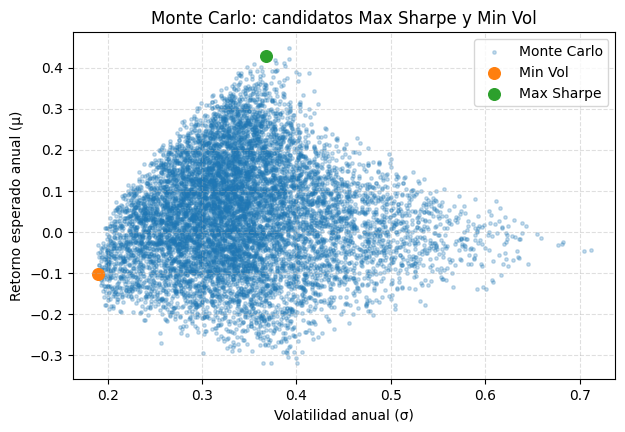

In [20]:
print("Candidatos seleccionados (métricas y pesos)")
display(tabla_5_1)



plt.figure(figsize=(7,4.5))
plt.scatter(mc_df["ann_vol"], mc_df["ann_returns"], s=6, alpha=0.25, label="Monte Carlo")
plt.scatter(cand_min_vol["ann_vol"], cand_min_vol["ann_returns"], s=70, label="Min Vol")
plt.scatter(cand_max_sharpe["ann_vol"], cand_max_sharpe["ann_returns"], s=70, label="Max Sharpe")
plt.xlabel("Volatilidad anual (σ)")
plt.ylabel("Retorno esperado anual (μ)")
plt.title("Monte Carlo: candidatos Max Sharpe y Min Vol")
plt.grid(True, ls="--", alpha=0.4); plt.legend(); plt.show()

### 5.2. Presente una tabla comparativa con:
-   Pesos por activo.
-   Retorno esperado anual.
-   Volatilidad anual.
-   Ratio de Sharpe.

In [21]:
porta = Do_portfolio(tickers, start=start_est, end=end_est)

# Construir la tabla (Nota: elige si quieres PMV con lb o no)
tabla_5_2, detalles = porta.compare_candidates_5_2(
    mu=mu, Sigma=Sigma, rf_ann=rf_ann_scalar,
    include_pmv_bounded=True,  # pon False si quieres el PMV "puro"
    lb=0.01, ub=1.0,           # cota inferior 1% por activo
    include_markowitz_target=True,
    mu_target=float(mu.mean()),  # o el μ* que quieras
    include_mc=True,
    n_port=10000, seed=42,
    return_details=True
)

tabla_5_2.round(4)

/home/fabian/miniconda3/lib/python3.12/site-packages/scs/__init__.py:83: UserWarning:

Converting A to a CSC (compressed sparse column) matrix; may take a while.



,Portafolio,μ_ann,σ_ann,Sharpe,w_AAPL,w_CX,w_TSLA,w_BTC-USD,w_MCD
0,PMV (lb=1.00%),0.0593,0.1898,0.0919,0.0261,0.0595,0.0100,0.1475,0.7569
1,Tangente,0.4074,0.3866,0.9453,0.0000,0.9204,0.0000,0.0796,0.0000
2,Markowitz(μ*=-0.014),0.0620,0.1891,0.1062,0.0346,0.0617,0.0000,0.1531,0.7506
3,MC Max Sharpe,0.4293,0.3676,1.0540,0.0014,0.2019,0.7544,0.0233,0.0191
4,MC Min Vol,-0.1034,0.1894,-0.7673,0.0639,0.1406,0.0204,0.7660,0.0092


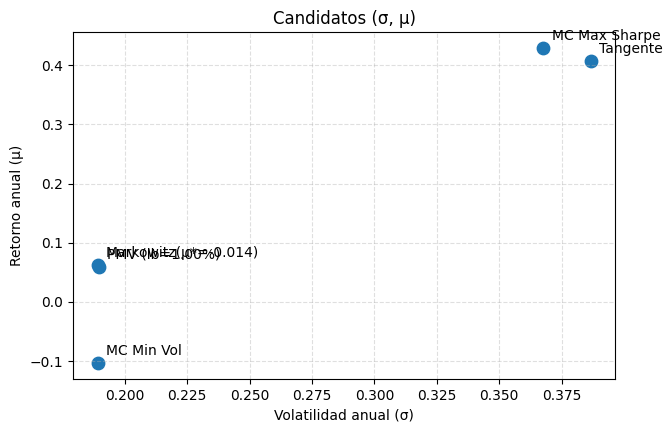

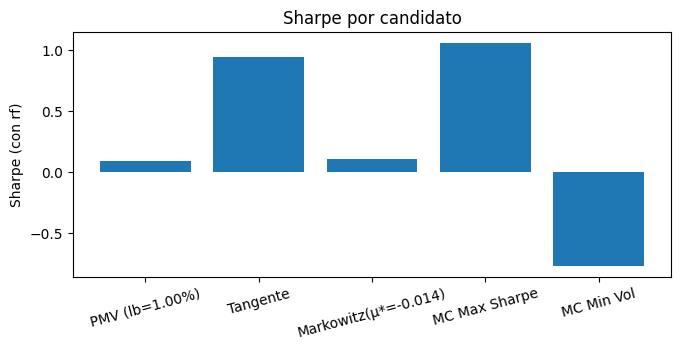

In [30]:
# Scatter σ–μ
plt.figure(figsize=(7,4.5))
plt.scatter(tabla_5_2["σ_ann"], tabla_5_2["μ_ann"], s=80)
for i, r in tabla_5_2.iterrows():
    plt.annotate(r["Portafolio"], (r["σ_ann"], r["μ_ann"]), xytext=(6,6), textcoords="offset points")
plt.xlabel("Volatilidad anual (σ)"); plt.ylabel("Retorno anual (μ)")
plt.title("Candidatos (σ, μ)"); plt.grid(True, ls="--", alpha=0.4); plt.show()

# Barras Sharpe
plt.figure(figsize=(7,3.6))
plt.bar(tabla_5_2["Portafolio"], tabla_5_2["Sharpe"])
plt.ylabel("Sharpe (con rf)"); plt.title("Sharpe por candidato")
plt.xticks(rotation=15); plt.tight_layout(); plt.show()


# 6. Backtesting

### 6.1. Usando los pesos hallados en el periodo de estimacion, calcule la evolucion del valor del portafolio durante el periodo de backtesting (julio 2025 – 15 agosto 2025)

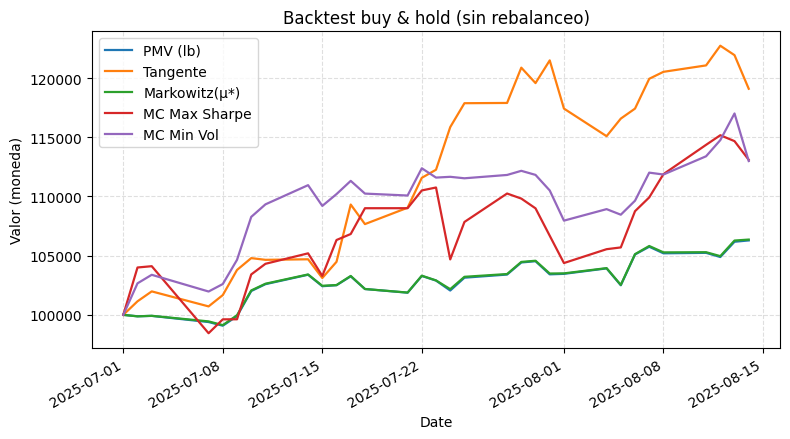

,Valor inicial,Valor final,Retorno total
PMV (lb),100000.0,106288.6537,0.0629
Tangente,100000.0,119102.4322,0.1910
Markowitz(μ*),100000.0,106361.4237,0.0636
MC Max Sharpe,100000.0,113097.5209,0.1310
MC Min Vol,100000.0,112994.9399,0.1299


In [ ]:
# Ventana de BACKTEST 
start_bt = "2025-07-01"
end_bt   = "2025-08-15"

# Reunir candidatos (reusa lo ya calculado; si falta, se calcula con tus métodos) 
candidatos = {}

# PMV (elige bounded si ya se uso en 4.1)
if 'pmv_eps' in globals():
    candidatos["PMV (lb)"] = pmv_eps                  # dict con 'weights'
elif 'pmv' in globals():
    candidatos["PMV"] = pmv                           # dict con 'weights'
else:
    candidatos["PMV"] = Do_portfolio.pmv_info(mu, Sigma, long_only=True)

# Tangente (máx Sharpe)
if 'tan' in globals():
    candidatos["Tangente"] = tan                      # dict con 'weights'
else:
    try:
        rf_ann_scalar = float(rf_ann.squeeze().iloc[-1])
    except Exception:
        rf_ann_scalar = float(rf_ann.iloc[-1])
    candidatos["Tangente"] = Do_portfolio.tangency_portfolio(
        mu, Sigma, rf_ann=rf_ann_scalar, long_only=True
    )

# Markowitz con μ* 
if 'res_target' in globals():
    candidatos["Markowitz(μ*)"] = res_target
else:
    mu_target = float(mu.mean())
    candidatos["Markowitz(μ*)"] = Do_portfolio.min_var_portfolio(
        mu, Sigma, target_return=mu_target, long_only=True
    )

# Monte Carlo: candidatos Max Sharpe y Min Vol
if 'cand_max_sharpe' in globals() and 'cand_min_vol' in globals():
    candidatos["MC Max Sharpe"] = cand_max_sharpe     # fila con w_TICKER y métricas
    candidatos["MC Min Vol"]    = cand_min_vol
else:
    porta_mc = Do_portfolio(tickers, start=start_est, end=end_est)
    cands = porta_mc.pick_candidates(
        n_port=5000, short=False, rf=rf_ann_scalar, seed=42, periods_per_year=252
    )
    candidatos["MC Max Sharpe"] = cands["max Sharpe"]
    candidatos["MC Min Vol"]    = cands["min Vol"]

# Construir weights_map y correr backtest 
weights_map = {name: obj for name, obj in candidatos.items()}

runner = Do_portfolio(tickers, start=start_est, end=end_est)
values_bt = runner.run_backtest(
    weights_map, start_bt=start_bt, end_bt=end_bt, V0=100_000.0
)

# Gráfica de valores 
ax = values_bt.plot(figsize=(8,4.5), lw=1.6)
ax.set_ylabel("Valor (moneda)")
ax.set_title("Backtest buy & hold (sin rebalanceo)")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Resumen mínimo (valor final y retorno total) 
resumen = pd.DataFrame({
    "Valor inicial": values_bt.iloc[0],
    "Valor final":   values_bt.iloc[-1],
    "Retorno total": (values_bt.iloc[-1] / values_bt.iloc[0] - 1.0)
}).round(4)
display(resumen)

# retornos diarios del backtest para 6.2/6.3:
rets_bt = values_bt.pct_change().dropna()


### 6.2. Compare graficamente la evolucion de los tres portafolios.

In [24]:
# descarga ^IRX en la ventana del backtest
Yrf_bt = yahoo_data(["^IRX"], start=start_bt, end=end_bt)
# convierte a anual y diaria (reutiliza tu función)
rf_ann_bt, rf_daily_bt = yahoo_data.convert_rf(Yrf_bt.data[["^IRX"]])
rf_daily_bt = rf_daily_bt.squeeze()  # Serie

# Resumen de métricas 
metrics_6_2 = Do_portfolio.summarize_backtest(values_bt, rf_daily=rf_daily_bt, periods_per_year=252)
display(metrics_6_2.round(4))

# ordena por Sharpe o por Calmar:
display(metrics_6_2.sort_values("Sharpe", ascending=False).round(4))
display(metrics_6_2.sort_values("Calmar", ascending=False).round(4))


/media/fabian/INFO/Universidad externado/Defi3/portafolio_de_inversion/function/Methodologies_Port.py:784: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,CAGR,AnnVol,Sharpe,MaxDD,Calmar
PMV (lb),0.6418,0.1441,3.2280,-0.0195,32.9883
Tangente,3.1415,0.2720,5.2183,-0.0527,59.6035
Markowitz(μ*),0.6509,0.1428,3.2942,-0.0195,33.3651
MC Max Sharpe,1.7197,0.3565,2.8711,-0.0576,29.8407
MC Min Vol,1.6997,0.2371,4.1383,-0.0394,43.1692


,CAGR,AnnVol,Sharpe,MaxDD,Calmar
Tangente,3.1415,0.2720,5.2183,-0.0527,59.6035
MC Min Vol,1.6997,0.2371,4.1383,-0.0394,43.1692
Markowitz(μ*),0.6509,0.1428,3.2942,-0.0195,33.3651
PMV (lb),0.6418,0.1441,3.2280,-0.0195,32.9883
MC Max Sharpe,1.7197,0.3565,2.8711,-0.0576,29.8407


,CAGR,AnnVol,Sharpe,MaxDD,Calmar
Tangente,3.1415,0.2720,5.2183,-0.0527,59.6035
MC Min Vol,1.6997,0.2371,4.1383,-0.0394,43.1692
Markowitz(μ*),0.6509,0.1428,3.2942,-0.0195,33.3651
PMV (lb),0.6418,0.1441,3.2280,-0.0195,32.9883
MC Max Sharpe,1.7197,0.3565,2.8711,-0.0576,29.8407


- **CAGR**: retorno anual compuesto realizado en la ventana de prueba.
- **AnnVol**: volatilidad anual realizada.
- **Sharpe**: exceso de retorno frente a la tasa libre de riesgo diaria del backtest (mejor que usar la tasa de la etapa de estimacion).
- **MaxDD**: peor caida pico a valle (valor negativo).
- **Calmar**: CAGR dividido por el valor absoluto de MaxDD.

**Calmar en breve:** mide cuanto retorno anual compuesto obtienes por cada unidad de caida maxima.
Formula: Calmar = CAGR / |MaxDD|. Cuanto mas alto, mejor (mayor resiliencia a caidas profundas).


6.3. Analice cu´al metodolog´ıa present´o mejor desempe˜no en este periodo y por qu´e

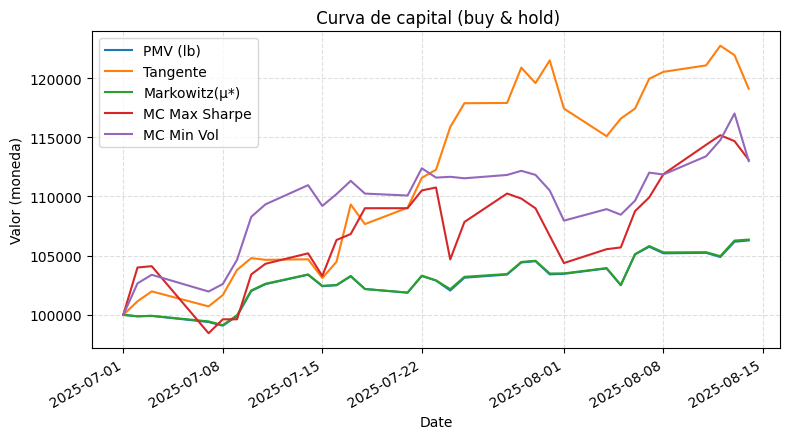

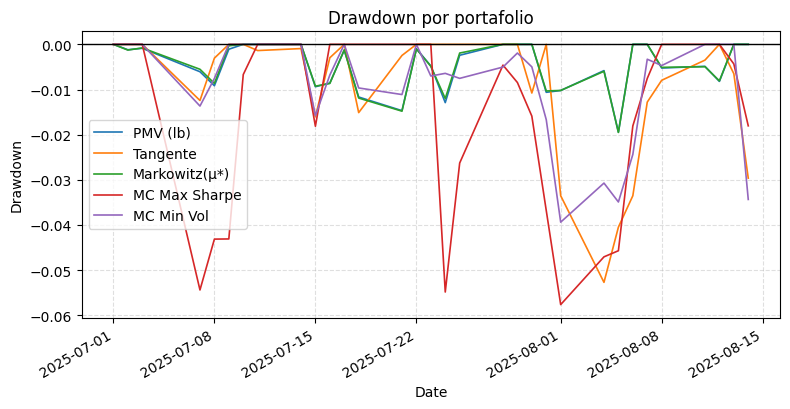

Tabla — Máximo drawdown y fechas:


,MaxDD,PeakDate,TroughDate,RecoveryDate,Days_Peak2Trough,Days_Trough2Rec
Portafolio,,,,,,
PMV (lb),-0.0195,2025-07-30,2025-08-05,2025-08-06,6,1
Tangente,-0.0527,2025-07-31,2025-08-04,2025-08-12,4,8
Markowitz(μ*),-0.0195,2025-07-30,2025-08-05,2025-08-06,6,1
MC Max Sharpe,-0.0576,2025-07-23,2025-08-01,2025-08-08,9,7
MC Min Vol,-0.0394,2025-07-22,2025-08-01,2025-08-11,10,10


In [ ]:
# Curvas de capital (ya estan en la 6.1, pero las dejamos aquí por completitud)
ax = values_bt.plot(figsize=(8,4.5), lw=1.5)
ax.set_ylabel("Valor (moneda)")
ax.set_title(" Curva de capital (buy & hold)")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()

# Drawdowns (líneas bajo cero)
dd, dd_resumen = Do_portfolio.drawdown(values_bt)
ax = dd.plot(figsize=(8,4.2), lw=1.2)
ax.axhline(0, color="black", lw=1)
ax.set_ylabel("Drawdown")
ax.set_title("Drawdown por portafolio")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()

print("Tabla — Máximo drawdown y fechas:")
display(Do_portfolio.dd_table(values_bt).round(4))




Rolling window usado: 21 días


/media/fabian/INFO/Universidad externado/Defi3/portafolio_de_inversion/function/Methodologies_Port.py:888: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



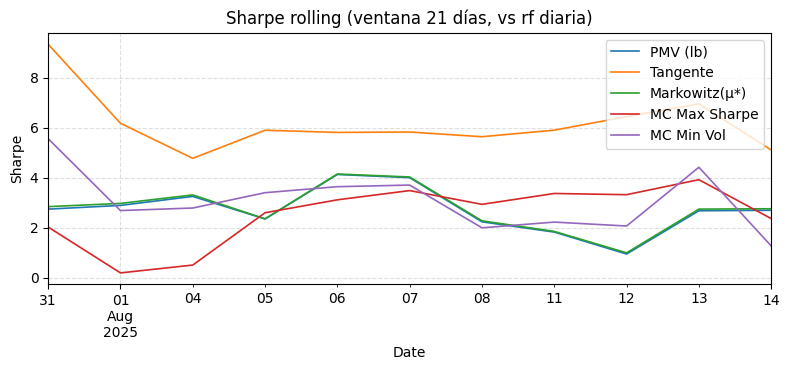

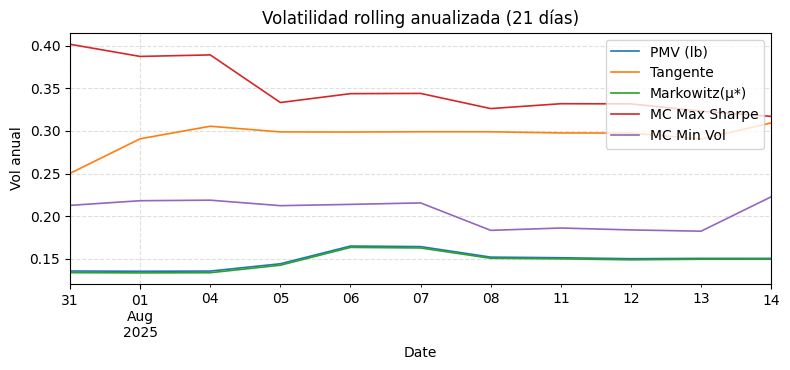

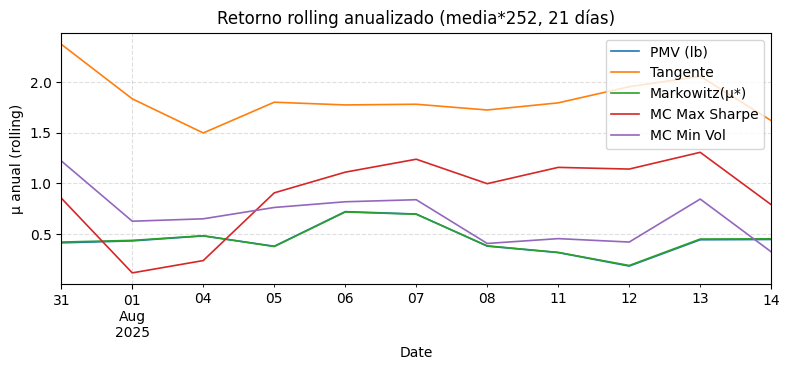

In [27]:
# elegir ventana que sí quepa en el backtest 
n_obs = len(values_bt)                  # filas de la curva de capital
win = max(10, min(21, n_obs - 1))      # usa 21 si se puede; mínimo 10; nunca > n_obs-1
print(f"Rolling window usado: {win} días")

# métricas móviles con la ventana elegida
roll = Do_portfolio.rolling_stats(values_bt, rf_daily=rf_daily_bt, window=win, periods_per_year=252)

#  Sharpe rolling 
sh = roll["sharpe"].dropna(how="all")   # elimina periodos 100% NaN al inicio
ax = sh.plot(figsize=(8,3.8), lw=1.2)
ax.set_title(f"Sharpe rolling (ventana {win} días, vs rf diaria)")
ax.set_ylabel("Sharpe"); ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()

# Volatilidad rolling 
vol = roll["vol"].dropna(how="all")
ax = vol.plot(figsize=(8,3.8), lw=1.2)
ax.set_title(f"Volatilidad rolling anualizada ({win} días)")
ax.set_ylabel("Vol anual"); ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()

#  Retorno rolling anualizado 
mu_roll = roll["mu"].dropna(how="all")
ax = mu_roll.plot(figsize=(8,3.8), lw=1.2)
ax.set_title(f"Retorno rolling anualizado (media*252, {win} días)")
ax.set_ylabel("μ anual (rolling)"); ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()
